In [2]:
import seaborn as sns 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sns.set_theme(color_codes=True)
sns.set_context("paper")

# Parameter
tau = 15

In [7]:
df = pd.read_csv("/usr/app/data/trippub.csv") 
df.head()

,HOUSEID,PERSONID,TDTRPNUM,STRTTIME,ENDTIME,TRVLCMIN,TRPMILES,TRPTRANS,TRPACCMP,TRPHHACC,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
0,30000007,1,1,1000,1015,15,5.244,3,0,0,...,20,750,300,50,750,300,350,30,300,300
1,30000007,1,2,1510,1530,20,5.149,3,0,0,...,30,300,300,50,1500,750,750,20,750,300
2,30000007,2,1,700,900,120,84.004,6,0,0,...,40,1500,750,50,1500,750,750,20,750,300
3,30000007,2,2,1800,2030,150,81.628,6,0,0,...,20,750,300,40,1500,750,750,40,1500,750
4,30000007,3,1,845,900,15,2.250,3,0,0,...,20,750,300,50,750,300,350,60,750,300


In [ ]:
df.shape

In [8]:
# Filter applied
# - TRPTRANS in [03, 04, 05, 06] || Mode of transportt (correspond to car, suv, van, pick up truck)
# - TRPHHVEH == '01' || Only if household vehicle is used
# - TRIPPURP in [HBO, HBSHOP, HBSCOREC, HBW]
# - TRPMILES must not be negative

# ?- Drop duplicates for combination HOUSEID + STRTTIME 

df_tmp = df[
        (df["TRPHHVEH"] == 1) 
        & (df["TRPTRANS"].isin([3, 4, 5, 6])) 
        & (df["TRIPPURP"].isin(["HBO", "HBSHOP", "HBSCOREC", "HBW"]))
        & (df["TRPMILES"] >= 0)
       ].copy()
df_tmp.shape


(423319, 115)

In [9]:
# STRTTIME for deriving probabilitiy of starting trip at time
print(df_tmp["STRTTIME"].describe())
df_tmp["STRTTIME"] = df_tmp["STRTTIME"].astype("str").apply(lambda x: int(x) if len(x) < 3 else int(int(x[0:-2])*60+int(x[-2:])))                                                         
df_tmp["STRTTIME"].describe()

count    423319.000000
mean       1307.102424
std         447.780932
min           0.000000
25%         915.000000
50%        1323.000000
75%        1700.000000
max        2359.000000
Name: STRTTIME, dtype: float64


count    423319.000000
mean        793.595778
std         268.588938
min           0.000000
25%         555.000000
50%         803.000000
75%        1020.000000
max        1439.000000
Name: STRTTIME, dtype: float64

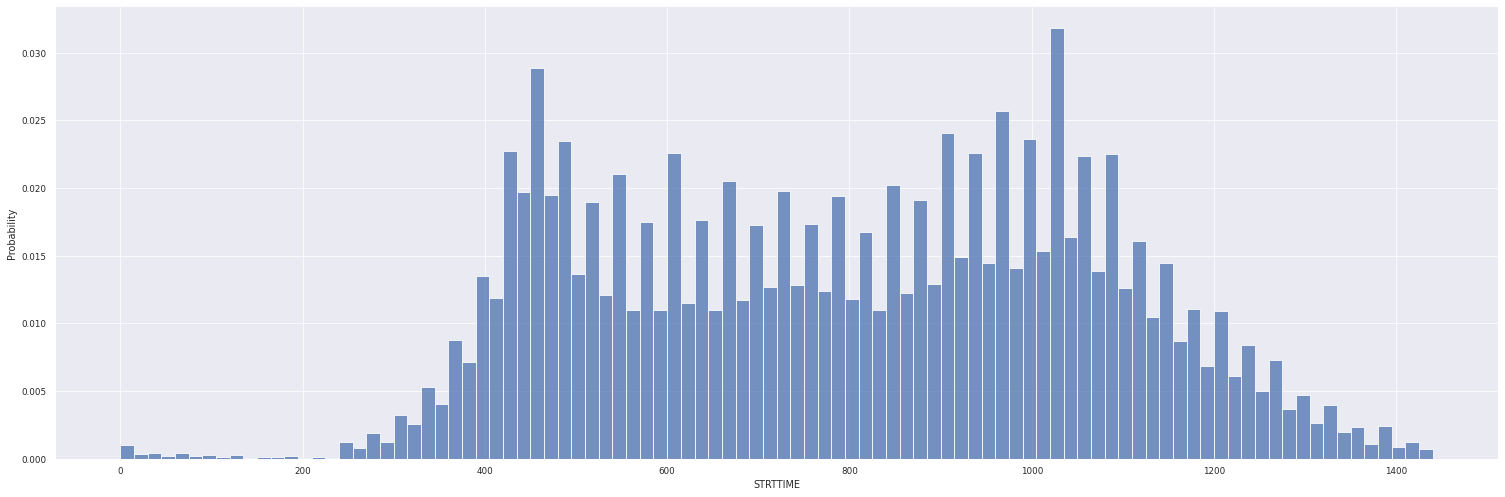

In [101]:
sns.displot(df_tmp, x="STRTTIME", stat="probability",bins=list(range(0,1441, tau)), height = 7, aspect = 3)

In [12]:
hist_strtttime = np.histogram(df_tmp["STRTTIME"], bins = list(range(0,1441, tau)), density = True)
d_strttime = pd.DataFrame(data = {"t": hist_strtttime[1][0:int(1441/tau)], "p(t)": hist_strtttime[0]*tau})
d_strttime[d_strttime["t"] < 450].tail(2)

,t,p(t)
28,420,0.022699
29,435,0.019671


In [9]:
d_strttime.to_pickle("/usr/app/data/probabilities/trpstrt.pkl") 

In [13]:
# TRPMILES for each STRTIIME for deriving probability of Triplengt
df_tmp["TRPMILES"].describe()

count    423319.000000
mean          9.447009
std          25.314659
min           0.000000
25%           1.981000
50%           4.380000
75%          10.017000
max        2926.713000
Name: TRPMILES, dtype: float64

In [14]:
k = 1

## Ensure that if trip is started but length is in interval [0,1) length must be greater zero to account for right decision making
## Set each trip length to mean of intervalls (1km intervalls => +0.5)
bins = [b+0.5 for b in range(0,41,k)]

#range(0, int(max(df_tmp["TRPMILES"])), int(max(df_tmp["TRPMILES"])/k))
d_len = pd.DataFrame(columns=["t"]+bins[:-1])

for t in d_strttime["t"]:
    hist_len = np.histogram(df_tmp.loc[df_tmp.STRTTIME==t, "TRPMILES"], bins = bins, density = True)
    d_len.loc[t,:] = [t]+list(hist_len[0]*k)
    
d_len

,t,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,...,30.5,31.5,32.5,33.5,34.5,35.5,36.5,37.5,38.5,39.5
0,0,0.0708661,0.0866142,0.106299,0.0866142,0.0472441,0.0511811,0.0551181,0.023622,0.0472441,...,0,0.00393701,0.00393701,0.00393701,0,0,0,0,0.00787402,0.00787402
15,15,0.0851064,0.106383,0.0425532,0.12766,0.12766,0.106383,0.0638298,0.0425532,0.0425532,...,0,0,0,0,0,0,0,0,0,0
30,30,0.0727273,0.0636364,0.0818182,0.0545455,0.0545455,0.0363636,0.0363636,0.0636364,0.0636364,...,0,0.00909091,0,0,0,0.00909091,0,0,0,0
45,45,0.0277778,0.0833333,0.111111,0.0833333,0.138889,0.138889,0,0,0.166667,...,0,0,0,0,0.0555556,0,0,0,0,0
60,60,0.0869565,0.0521739,0.0782609,0.113043,0.0173913,0.121739,0.0608696,0.0173913,0.026087,...,0.00869565,0,0,0.00869565,0,0.00869565,0.0173913,0,0.00869565,0.00869565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1365,1365,0.085,0.12,0.095,0.195,0.075,0.035,0.09,0.05,0.02,...,0.01,0,0,0.005,0.01,0.005,0,0.005,0.005,0.005
1380,1380,0.0800654,0.0849673,0.0849673,0.0767974,0.0816993,0.0506536,0.0522876,0.0506536,0.0326797,...,0.00653595,0.00653595,0.00653595,0.00816993,0.00490196,0.00163399,0.00326797,0.00653595,0.00163399,0.00163399
1395,1395,0.0703125,0.117188,0.117188,0.03125,0.0390625,0.046875,0.0703125,0.0546875,0.0390625,...,0,0,0,0,0.0078125,0.015625,0,0,0.0078125,0.0078125
1410,1410,0.0880503,0.0849057,0.0691824,0.0471698,0.0597484,0.072327,0.0345912,0.0503145,0.0345912,...,0.00314465,0.00314465,0.00314465,0.00314465,0,0.00628931,0.00628931,0.00943396,0,0.00314465


In [15]:
# Save distribution
d_len.to_pickle("/usr/app/data/probabilities/trplen.pkl") 

In [18]:
# Just for checking
d_len.loc[:,'sum'] = d_len.iloc[:,1:].sum(axis=1)
#d_len.iloc[:,1:]
d_len[d_len["t"] == 300].tail(1)

,t,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,...,31.5,32.5,33.5,34.5,35.5,36.5,37.5,38.5,39.5,sum
300,300,0.0495663,0.0433705,0.0260223,0.0322181,0.0446097,0.0322181,0.0446097,0.023544,0.0297398,...,0.0136307,0.0136307,0.0123916,0.0086741,0.0198265,0.00991326,0.0123916,0.0173482,0.0086741,3.0


In [19]:
d_len.tail()

,t,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,...,31.5,32.5,33.5,34.5,35.5,36.5,37.5,38.5,39.5,sum
1365,1365,0.085,0.12,0.095,0.195,0.075,0.035,0.09,0.05,0.02,...,0,0,0.005,0.01,0.005,0,0.005,0.005,0.005,3.0
1380,1380,0.0800654,0.0849673,0.0849673,0.0767974,0.0816993,0.0506536,0.0522876,0.0506536,0.0326797,...,0.00653595,0.00653595,0.00816993,0.00490196,0.00163399,0.00326797,0.00653595,0.00163399,0.00163399,3.0
1395,1395,0.0703125,0.117188,0.117188,0.03125,0.0390625,0.046875,0.0703125,0.0546875,0.0390625,...,0,0,0,0.0078125,0.015625,0,0,0.0078125,0.0078125,3.0
1410,1410,0.0880503,0.0849057,0.0691824,0.0471698,0.0597484,0.072327,0.0345912,0.0503145,0.0345912,...,0.00314465,0.00314465,0.00314465,0,0.00628931,0.00628931,0.00943396,0,0.00314465,3.0
1425,1425,0.12,0.096,0.088,0.104,0.104,0.032,0.016,0.056,0.032,...,0.016,0,0,0,0,0,0.008,0,0,3.0


In [20]:
pd.DataFrame([(p,np.percentile(df_tmp.loc[:, "TRPMILES"], p)) for p in range(90,101,1)])

### => 97% of trips have lenght <= 40.01500 miles

,0,1
0,90,20.08400
1,91,21.45000
2,92,22.98800
3,93,24.83174
4,94,27.09700
5,95,30.07510
6,96,34.17556
7,97,40.01500
8,98,50.36464
9,99,79.56200


<AxesSubplot:xlabel='Length', ylabel='t'>

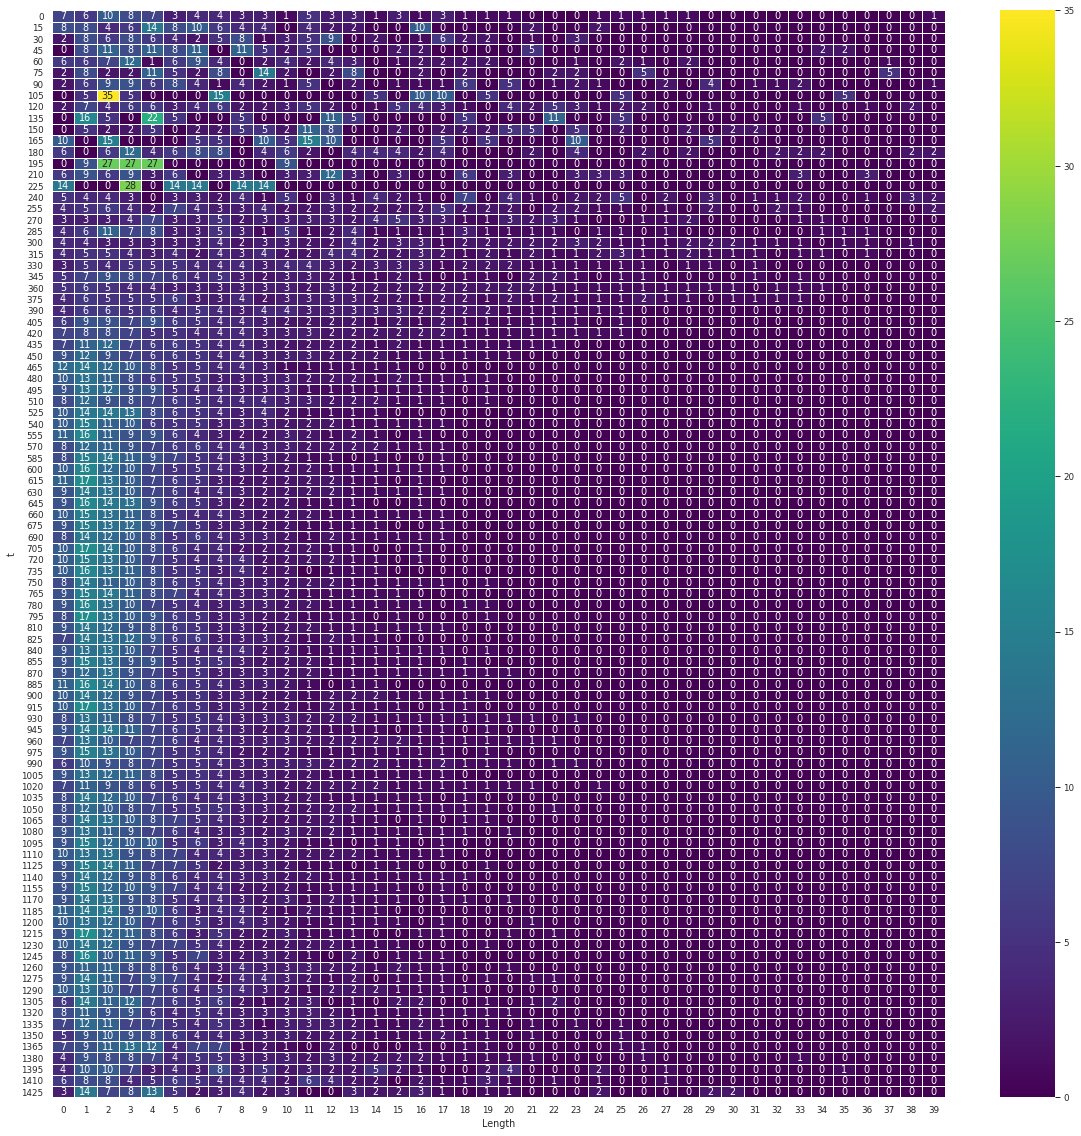

In [133]:
df_plot = pd.melt(d_len.iloc[:,:-1].copy(), id_vars=['t'], var_name = "Length", value_name = "d(t)")
df_plot["d(t)"] = df_plot["d(t)"]*100
df_plot["d(t)"] = df_plot["d(t)"].astype("int32")
df_pivot = df_plot.pivot("t", "Length", "d(t)")

# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df_pivot, annot=True, fmt="d", linewidths=.5, ax=ax,cmap = sns.color_palette("viridis", as_cmap=True))

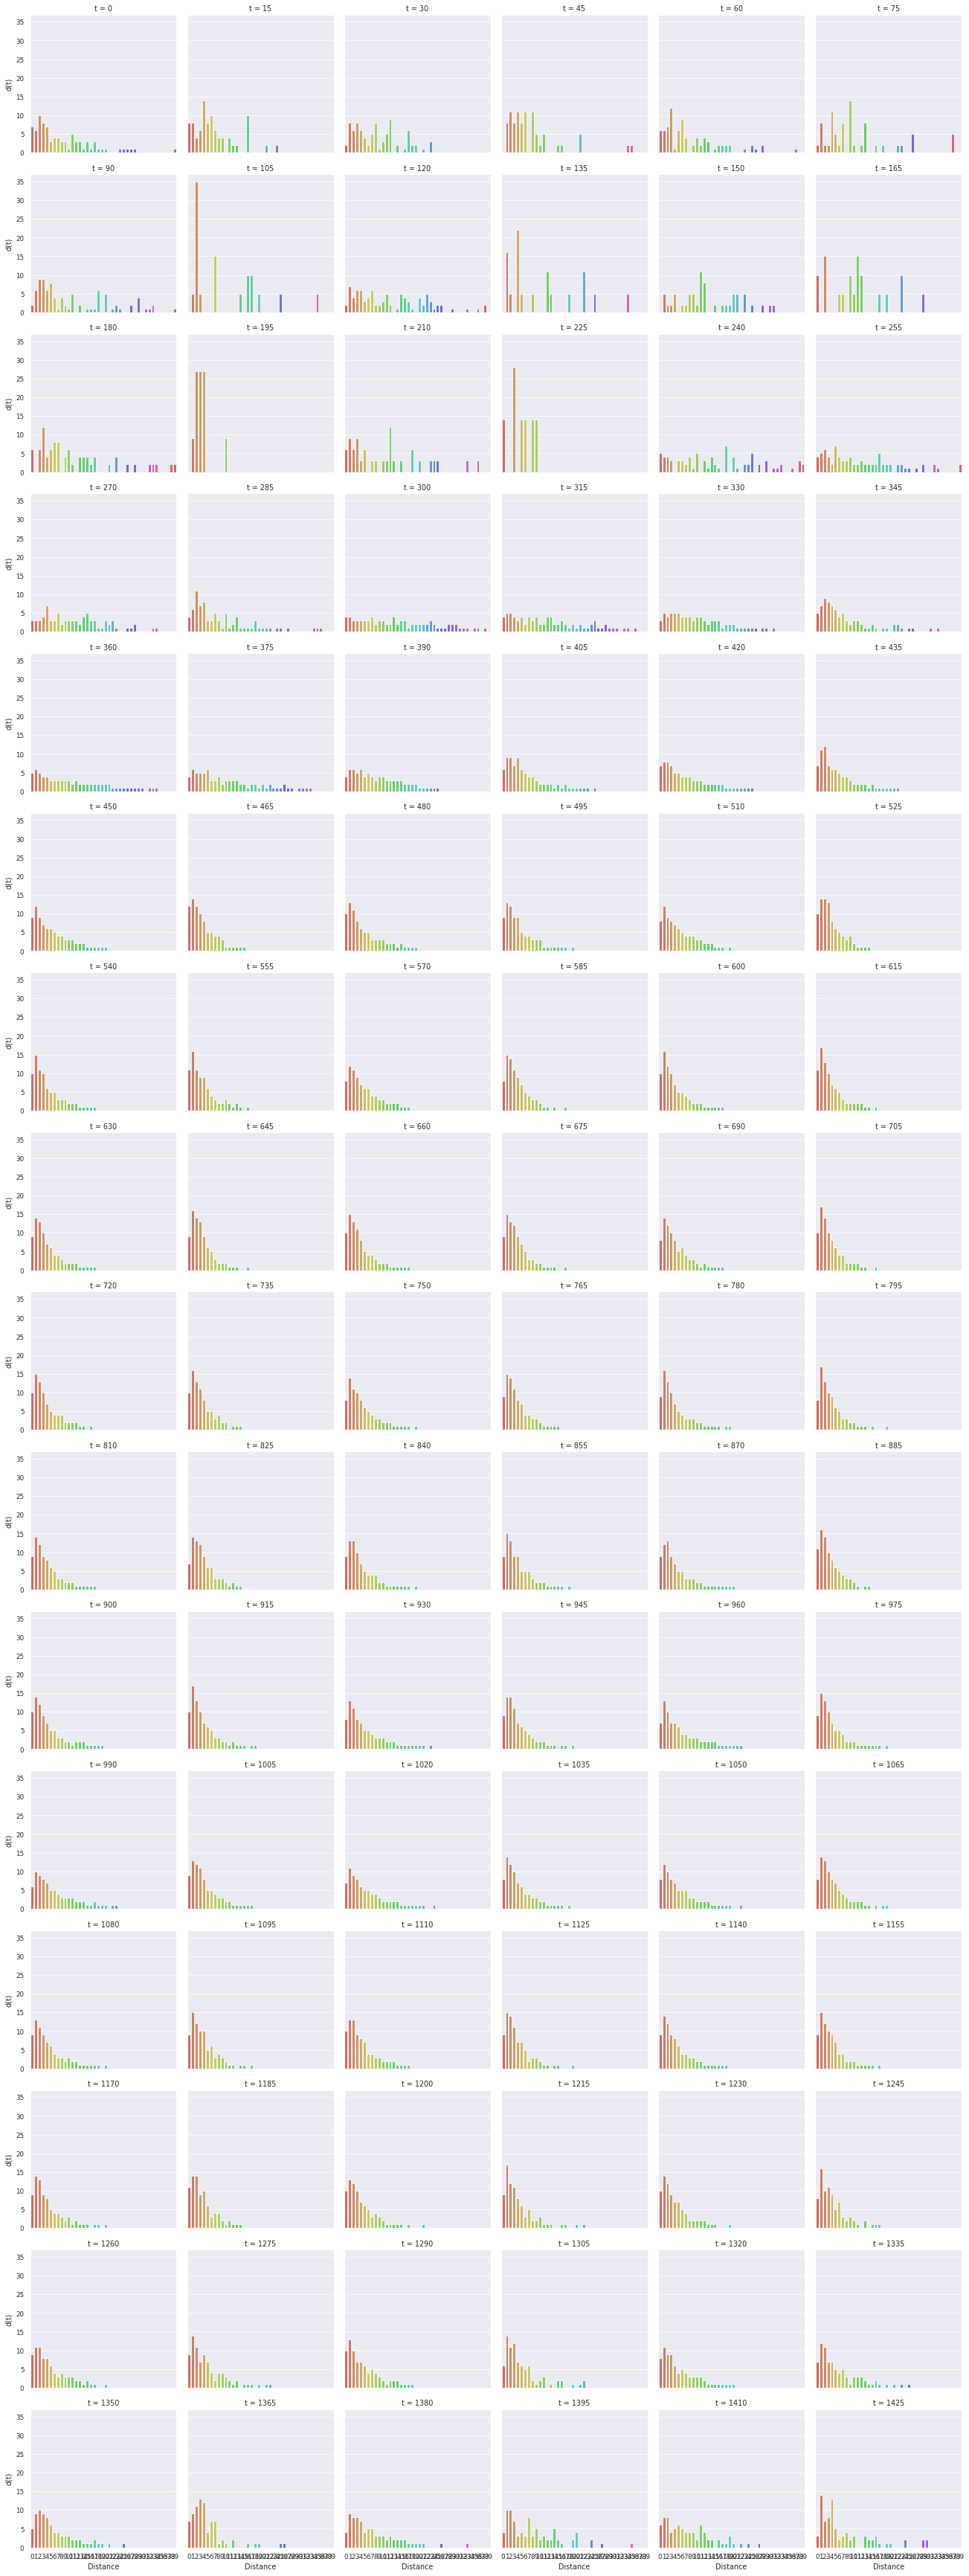

In [134]:
g = sns.FacetGrid(df_plot, col="t", col_wrap = 6)
g.map_dataframe(sns.barplot, x="Length", y="d(t)", palette = sns.color_palette("hls", len(df_plot["Length"].unique())))
g.set_axis_labels("Distance", "d(t)")

<AxesSubplot:xlabel='Length', ylabel='d(t)'>

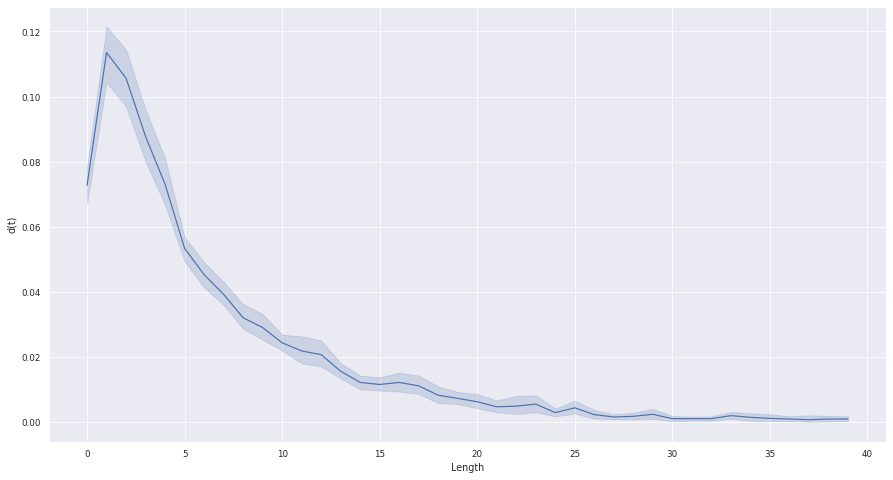

In [135]:
plt.figure(figsize=(15,8))
sns.lineplot(x=df_plot["Length"], y=df_plot["d(t)"]/100,legend = False,
            )# hue=df_plot["strttime"], palette = sns.color_palette("hls", len(df_plot["strttime"].unique())))

[ 10.57117079 107.29667597  23.64715715]
[0.03255371 0.0396201  0.04668648 0.05375287]
(array([ 10.57117079, 107.29667597,  23.64715715]), array([0.03255371, 0.0396201 , 0.04668648, 0.05375287]))


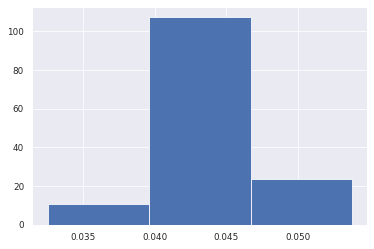

In [30]:
# Read in excel
prc = pd.read_csv("/usr/app/data/input/Price_avg.csv", sep=";")

# Calculate euro/kWh
prc[["Year","Winter","Sommer"]] = prc[["Year","Winter","Sommer"]]/1000

# Derive normal distribution for each point in time (sd is mean-lower = upper-mean)
s = np.random.normal(prc.loc[0,"Year"], abs(prc.loc[0,"Year"]-prc.loc[0,"Winter"]), 10000)

# Derive histrogram from normal distribution with 3 bins
count, bins, ignored = plt.hist(s, 3, density=True)
hist = np.histogram(s, bins = 3, density = True)
# TODO get probabilities => 10.57*intervall of bar

# Export probabilities
print(count)
print(bins)
print(hist)